In [220]:
import pandas

import pygsheets
import numpy
import scipy
import re

import matplotlib
import matplotlib.pyplot as mp
import matplotlib.cm

import textwrap
import seaborn

## define colors used in bars

In [221]:
sel_cmap = matplotlib.cm.get_cmap('Reds')
tracker_operating = sel_cmap(0.999)
tracker_construction = sel_cmap(0.8)
tracker_proposed = sel_cmap(0.6)
tracker_shelved = sel_cmap(0.4)
tracker_cancelled = sel_cmap(0.2)

/var/folders/fl/t07mc8053p33mn6mdmvp45580000gn/T/ipykernel_8458/1445812906.py:1: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  sel_cmap = matplotlib.cm.get_cmap('Reds')


# import data directly from google sheets

In [222]:
gc = pygsheets.authorize(service_account_env_var='GDRIVE_API_CREDENTIALS')
spreadsheet = gc.open_by_key('1foPLE6K-uqFlaYgLPAUxzeXfDO5wOOqE7tibNHeqTek')
#spreadsheet = gc.open_by_key('1EFL6doEFF_jAjOuRO7OeGRqG2z-EI1B2_q2cEgvmSro') # Apr 2023 version for oil pipelines release

#spreadsheet[1] "oil Pipelines" tab is the second index
gas_pipes = spreadsheet.worksheet('title','Gas pipelines').get_as_df(start='A3')
oil_pipes = spreadsheet.worksheet('title', 'Oil/NGL pipelines').get_as_df(start='A3')

pipes_df_orig = oil_pipes.copy() #pandas.concat([gas_pipes, oil_pipes], ignore_index=True)

#get country ratios sheet
country_ratios_df = spreadsheet.worksheet('title', 'Country ratios by pipeline').get_as_df()

In [223]:
#fuel_type = 'Gas'
fuel_type = 'Oil'
#fuel_type = 'NGL'

# if fuel_type=='Gas':
#     fuel_options = ['Gas']
# if fuel_type=='NGL':
#     fuel_options = ['NGL', 
#                     'NGL, oil products', 
#                     'Oil, NGL', 
#                     'Oil, NGL, naphtha']
# if fuel_type=='Oil':
#     fuel_options = ['Oil', 
#                     'Oil, NGL', 
#                     'Oil, NGL, naphtha']

gas_fuel_options = ['Gas']
ngl_fuel_options = ['NGL', 
                    'NGL, oil products', 
                    'Oil, NGL', 
                    'Oil, NGL, naphtha']
oil_fuel_options = ['Oil', 
                    'Oil, NGL', 
                    'Oil, NGL, naphtha']

In [224]:
owners_df_orig = spreadsheet.worksheet('title', 'Pipeline operators/owners (1/3)').get_as_df(start='A2')
owners_df_orig = owners_df_orig.loc[owners_df_orig.ProjectID!='']
owners_df_orig = owners_df_orig.loc[owners_df_orig.Wiki!='']
owners_df = owners_df_orig.replace('',numpy.nan)

owner_parent_links_df = spreadsheet.worksheet('title', 'Owner–parent relationships (2/3)').get_as_df(start='A2')
# only keep the owners with a checked relationship
owner_parent_links_df = owner_parent_links_df.loc[owner_parent_links_df['Parent–Owner Relationship Checked?']=='yes']
owner_parent_links_df.replace('',numpy.nan,inplace=True)

parents_df = spreadsheet.worksheet('title', 'Parent metadata (3/3)').get_as_df(start='A2')
parents_df = parents_df.loc[parents_df.Parent!='']

owners_df.set_index('ProjectID', inplace=True)
owner_parent_links_df.set_index('Owner', inplace=True)
parents_df.set_index('Parent', inplace=True)

# ****************************************

## create list of owner and parent column names
owner_pct_col_names = []
owner_col_names = []

parent_pct_col_names = []
parent_col_names = []

for num in range(1,11+1):
    owner_pct_col = f'Owner{num}%'
    owner_pct_col_names.append(owner_pct_col)
    
    owner_col = f'Owner{num}'
    owner_col_names.append(owner_col)
    
    parent_pct_col = f'Parent{num}%'
    parent_pct_col_names.append(parent_pct_col)
    
    parent_col = f'Parent{num}'
    parent_col_names.append(parent_col)

# ****************************************
## fill in missing parent info by borrowing owner info
owners_FULL_set = owners_df[owner_col_names].stack().dropna().unique().tolist() # from owners_df
owners_researched_set = list(set(owner_parent_links_df.index.to_list()))#+['Unknown'] # only existing owners, plus 'Unknown'
owners_diff = list(set(owners_FULL_set)-set(owners_researched_set))
owners_diff.append('Unknown')

# update owner_parent_links_df with these extra owners
owner_parent_links_df = pandas.concat([owner_parent_links_df, pandas.DataFrame(index=owners_diff, columns=owner_parent_links_df.columns)])
owner_parent_links_df['Parent1'].loc[owners_diff] = owners_diff
owner_parent_links_df['Parent1%'].loc[owners_diff] = '100.00%'

# ****************************************
# update parents_df with these as well
# note countries will be unknkown...
parents_set = list(set(parents_df.index.to_list()))
parents_diff = list(set(owners_diff)-set(parents_set))
parents_diff.append('Unknown')
parents_df = pandas.concat([parents_df, pandas.DataFrame(numpy.nan, index=parents_diff, columns=parents_df.columns)])
parents_df.loc[parents_diff,'ParentHQCountry'] = 'Unknown'

/var/folders/fl/t07mc8053p33mn6mdmvp45580000gn/T/ipykernel_8458/2705967703.py:49: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  owner_parent_links_df['Parent1'].loc[owners_diff] = owners_diff
/var/folders/fl/t07mc8053p33mn6mdmvp45580000gn/T/

## replace "--" with NaN, removing empty rows

the dataset is structured to have -- wherever there's a lookup value that doesn't exist; replacing it with NaN (numpy.nan) allows pandas to treat it as a null value, which makes calculations much easier

In [225]:
# replace -- entries with NaN
pipes_df_orig = pipes_df_orig.replace('--', numpy.nan)
pipes_df_orig = pipes_df_orig[pipes_df_orig['PipelineName']!='']
pipes_df_orig = pipes_df_orig[pipes_df_orig['Wiki']!='']
country_ratios_df.replace('--', numpy.nan, inplace=True)

/var/folders/fl/t07mc8053p33mn6mdmvp45580000gn/T/ipykernel_8458/3383564205.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pipes_df_orig = pipes_df_orig.replace('--', numpy.nan)
/var/folders/fl/t07mc8053p33mn6mdmvp45580000gn/T/ipykernel_8458/3383564205.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  country_ratios_df.replace('--', numpy.nan, inplace=True)


# km by country, km by region calculations

In [226]:
status_list = ['proposed', 'construction', 'shelved', 'cancelled', 'operating', 'idle', 'mothballed', 'retired']
country_list = sorted(list(set(country_ratios_df['Country'])))
region_list = sorted(list(set(country_ratios_df['Region'])))

In [227]:
country_ratios_oil_df = country_ratios_df[country_ratios_df.Fuel.isin(oil_fuel_options)]

km_by_country_df = pandas.DataFrame(columns=status_list, index=country_list)
km_by_region_df = pandas.DataFrame(columns=status_list, index=region_list)

print('===country-level calculations===')
for status in status_list:
    print(status)
    country_ratios_oil_df_status = country_ratios_oil_df[country_ratios_oil_df['Status']==status]
    km_by_country_df[status] = country_ratios_oil_df_status.groupby('Country')['MergedKmByCountry'].sum()

print('===regional calculations===')
for status in status_list:
    print(status)
    country_ratios_oil_df_status = country_ratios_oil_df[country_ratios_oil_df['Status']==status]
    km_by_region_df[status] = country_ratios_oil_df_status.groupby('Region')['MergedKmByCountry'].sum()

# # fill NaN with 0.0
km_by_region_df = km_by_region_df.fillna(0)
km_by_country_df = km_by_country_df.fillna(0)

===country-level calculations===
proposed
construction
shelved
cancelled
operating
idle
mothballed
retired
===regional calculations===
proposed
construction
shelved
cancelled
operating
idle
mothballed
retired


In [228]:
km_by_region_df['proposed+construction'] = km_by_region_df[['proposed','construction']].sum(axis=1)
km_by_region_df.sort_values(by='proposed+construction', inplace=True)
km_by_region_df = km_by_region_df[['proposed', 'construction', 'proposed+construction', 'shelved', 'cancelled', 'operating', 'idle', 'mothballed', 'retired']]
km_by_region_df.sort_values('proposed+construction', ascending=False, inplace=True)

In [229]:
km_by_country_df['proposed+construction'] = km_by_country_df[['proposed','construction']].sum(axis=1)
km_by_country_df.sort_values(by='proposed+construction', inplace=True)
km_by_country_df = km_by_country_df[['proposed', 'construction', 'proposed+construction', 'shelved', 'cancelled', 'operating', 'idle', 'mothballed', 'retired']]
km_by_country_df.sort_values('proposed+construction', ascending=False, inplace=True)

In [231]:
km_by_region_df.sum()

proposed                  25419.94
construction              11941.15
proposed+construction     37361.09
shelved                    9612.49
cancelled                 67647.14
operating                338850.50
idle                       3654.04
mothballed                 6096.47
retired                   17555.40
dtype: float64

# for NGL

# projects by country, by region

In [196]:
country_ratios_oil_df = country_ratios_df[country_ratios_df.Fuel.isin(oil_fuel_options)]

num_by_country_df = pandas.DataFrame(columns=status_list, index=country_list)
num_by_region_df = pandas.DataFrame(columns=status_list, index=region_list)

print('===country-level calculations===')
for status in status_list:
    print(status)
    country_ratios_oil_df_status = country_ratios_oil_df[country_ratios_oil_df['Status']==status]
    num_by_country_df[status] = country_ratios_oil_df_status.groupby('ProjectID')['MergedKmByCountry'].sum()

print('===regional calculations===')
for status in status_list:
    print(status)
    country_ratios_oil_df_status = country_ratios_oil_df[country_ratios_oil_df['Status']==status]
    num_by_region_df[status] = country_ratios_oil_df_status.groupby('Region')['MergedKmByCountry'].sum()

# # fill NaN with 0.0
num_by_region_df = num_by_region_df.fillna(0)
num_by_country_df = num_by_country_df.fillna(0)

===country-level calculations===
proposed
construction
shelved
cancelled
operating
idle
mothballed
retired
===regional calculations===
proposed
construction
shelved
cancelled
operating
idle
mothballed
retired


# for NGL

# numbers of pipes finished in a given year

In [197]:
# count pipelines that are already operating
pipes_started = pipes_df_orig.copy()
pipes_started['StartYearEarliest'] = pipes_started['StartYearEarliest'].replace(numpy.nan,'')#,inplace=True)
pipes_started = pipes_started[(pipes_started['Status'].isin(['operating'])) &
                              (pipes_started.Fuel.isin(oil_fuel_options))]
pipes_started_sum = pipes_started.groupby('StartYearEarliest')['LengthMergedKm'].sum()

In [198]:
# count km of pipeline for each start year
pipes_started_startyear = pipes_df_orig.copy()
pipes_started_startyear['StartYearEarliest'] = pipes_started_startyear['StartYearEarliest'].replace(numpy.nan,'')#,inplace=True)
pipes_started_startyear = pipes_started_startyear[(pipes_started_startyear['Status'].isin(['operating'])) &
                              (pipes_started_startyear.Fuel.isin(oil_fuel_options))]
#pipes_started_startyear_sum = pipes_started_startyear.groupby('StartYearLatest')['LengthMergedKm'].sum()

In [199]:
# indev pipelines = proposed or construction or shelved
pipes_indev = pipes_df_orig.copy()
pipes_indev = pipes_indev.loc[(pipes_indev.Fuel.isin(oil_fuel_options))&
                              (pipes_indev.Status.isin(['proposed','construction','shelved']))].groupby('Status')['LengthMergedKm'].sum()
#pipes_indev = pipes_indev.loc[(pipes_indev.StartYearEarliest>2022)|
#                              (pipes_indev.StartYearEarliest.isna())].groupby('Status')['LengthMergedKm'].sum()

In [200]:
pipes_indev_to2030 = pipes_df_orig.copy()
pipes_indev_to2030 = pipes_indev_to2030.loc[(pipes_indev_to2030.Fuel.isin(oil_fuel_options)) &
                                        (pipes_indev_to2030['Status'].isin(['proposed','construction','shelved'])) &
                                        (pipes_indev_to2030['StartYearEarliest'].isin(list(range(2024,2031))))]
pipes_indev_to2030 = pipes_indev_to2030.groupby('Status')['LengthMergedKm'].sum()


In [201]:
pipes_indev_startyear = pipes_df_orig.copy()
pipes_indev_startyear = pipes_indev_startyear[(pipes_indev_startyear['Status'].isin(['proposed','construction','shelved'])) &
                                              (pipes_indev_startyear.Fuel.isin(oil_fuel_options))]
pipes_indev_startyear = pipes_indev_startyear.groupby(['Status','StartYearEarliest'], dropna=False)['LengthMergedKm'].sum(min_count=1)

In [202]:
pipes_indev_startyear.unstack()

StartYearEarliest,2021.0,2023.0,2024.0,2025.0,2026.0,2027.0,2030.0,NaN
Status,,,,,,,,
construction,NaN,NaN,6404.58,755.18,NaN,NaN,NaN,3702.74
proposed,NaN,NaN,2632.26,2804.33,2309.41,363.29,20.0,12723.54
shelved,1013.88,536.0,NaN,NaN,NaN,600.00,4800.0,2662.52


In [203]:
pipes_indev_startyear['construction',2024]

6404.58

# for NGL

## Fig 2 - 2023–2030, go back to 2008

## future/past plot

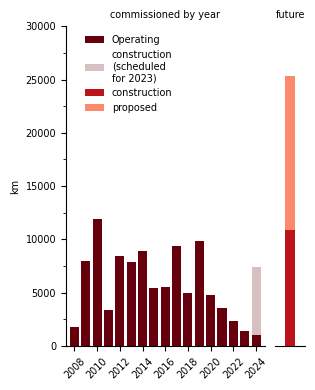

In [204]:
font_size = 7

ytop = 30000
ytop2 = 30000
xlo = 2008
xhi = 2024

fig = mp.figure(figsize=(3.25,4))

widths=[15,2.25]
spec = fig.add_gridspec(ncols=2, nrows=1, width_ratios=widths)

ax = fig.add_subplot(spec[0,0])

ax.bar(pipes_started_sum.loc[range(xlo,xhi+1)].index.values, pipes_started_sum.loc[range(xlo,xhi+1)].values,
       color=tracker_operating, label='Operating') # color=solar_base03

ax.bar(2024,pipes_indev_startyear['construction',2024],
       label='construction\n(scheduled\nfor 2023)', bottom=pipes_started_sum.loc[2024], 
       facecolor=tracker_operating, alpha=0.25)

ax.tick_params(labelsize=font_size)
ax.tick_params('x', rotation=45)
ax.set_ylabel('km', size=font_size)

ax.set_xlim(xlo-0.75, xhi+0.75)
ax.set_ylim(0, ytop)

ax.xaxis.set_major_locator(matplotlib.ticker.MaxNLocator(integer=True))

ax2 = fig.add_subplot(spec[0,1])
ax2.set_ylim(0, ytop2)
ax2.set_xlim(0.25,2.75)
xvals = [1.5]

colors = [tracker_construction, tracker_proposed]#, tracker_shelved]
status = ['construction', 'proposed']#, 'shelved']
ax2_list = []


ax2_list.append(ax2.bar(xvals[0], pipes_indev['construction'],
                 color=tracker_construction, label='construction'))

ax2_list.append(ax2.bar(xvals[0], pipes_indev['proposed']-pipes_indev_startyear['construction',2024],
                        bottom=pipes_indev['construction'],
                 color=tracker_shelved, label='proposed'))

ax_h, ax_l = ax.get_legend_handles_labels()
ax2_h, ax2_l = ax2.get_legend_handles_labels()

ax2.set_xticklabels([])
ax2.tick_params(labelsize=font_size)
ax2.set_xticks([])

ax2.set_yticks([])

ax.legend(handles=ax_h+ax2_h, fontsize=font_size, frameon=False, 
          loc='upper left', bbox_to_anchor=[0.05,1])

axpos = ax.get_position()
ax2pos = ax2.get_position()

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
#ax.spines['bottom'].set_visible(False)

ax2.spines['left'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
#ax2.spines['right'].set_visible(False)

ax.set_title('commissioned by year', fontsize=font_size)
ax2.set_title('future', fontsize=font_size)

fig.tight_layout(w_pad=0.5)

ax.yaxis.set_minor_locator(matplotlib.ticker.AutoMinorLocator(2))
#ax2.yaxis.set_minor_locator(matplotlib.ticker.AutoMinorLocator(2))

mp.savefig('saved-figures/oil-pipelines_km-by-start-year.png', bbox_inches='tight', transparent=True, dpi=600)
mp.savefig('saved-figures/oil-pipelines_km-by-start-year.pdf', bbox_inches='tight', transparent=True)

In [205]:
pipes_indev

Status
construction    10862.50
proposed        20852.83
shelved          9612.40
Name: LengthMergedKm, dtype: float64

## percent pipelines with start date (sanity check)

In [206]:
pipes_scratch = pipes_df_orig.copy()
pipes_scratch = pipes_scratch[(pipes_scratch.Fuel.isin(oil_fuel_options)) &
                              (pipes_scratch['Status'].isin(['proposed','construction','shelved']))]

In [207]:
pipes_scratch[~pipes_scratch['StartYearEarliest'].isnull()]['StartYearEarliest'].count()/pipes_scratch.shape[0]


0.44680851063829785

## regional pipelines started in given year

In [208]:
years_array = numpy.arange(float(pipes_df_orig['StartYearEarliest'].min()), 
                           float(pipes_df_orig['StartYearEarliest'].max())+1)
regions_startyear_sums_df = pandas.DataFrame(numpy.nan, index=years_array, columns=region_list)

In [209]:
#pipes_started = pipes_df.copy()[(pipes_df['Status'].isin(['Operating'])) & pipes_df['Fuel']=='oil']
#pipes_started_sum = pipes_started.groupby('StartYearLatest')['LengthMergedKm'].sum()

for region in region_list:
    pipes_started = pipes_df_orig.copy()[(pipes_df_orig['Status'].isin(['Operating','Retired','Idle'])) & 
                                    (pipes_df_orig['Fuel']=='oil')]
    pipes_started = pipes_started[pipes_started['StartRegion']==region]
    pipes_started_sum_up = pipes_started.groupby('StartYearEarliest')['LengthMergedKm'].sum()
    
    regions_startyear_sums_df[region] = pipes_started_sum_up

In [210]:
if len(region_list)!=10:
    region_list = region_list[2:]

# top 20 countries proposed+construction

In [211]:
def adjust_spines(ax, spines):
    for loc, spine in ax.spines.items():
        if loc in spines:
            spine.set_position(('outward', 10))  # outward by 10 points
        else:
            spine.set_color('none')  # don't draw spine

    # turn off ticks where there is no spine
    if 'left' in spines:
        ax.yaxis.set_ticks_position('left')
    else:
        # no yaxis ticks
        ax.yaxis.set_ticks([])

    if 'bottom' in spines:
        ax.xaxis.set_ticks_position('bottom')
    else:
        # no xaxis ticks
        ax.xaxis.set_ticks([])

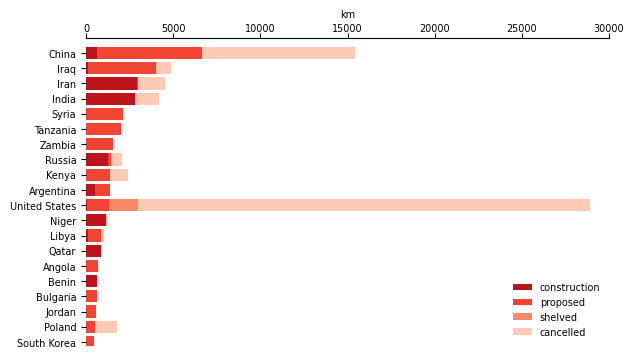

In [212]:
font_size = 7
fig = mp.figure(figsize=(6.75,4))
nbars=20

country_order = km_by_country_df.index[:nbars][::-1]

ax = fig.add_subplot(111)

ax.barh(numpy.arange(nbars), 
        km_by_country_df.loc[country_order]['construction'].values, 
        facecolor=tracker_construction,#solar_orange, 
        label='construction')

ax.barh(numpy.arange(nbars), 
        km_by_country_df.loc[country_order]['proposed'].values, 
        left=km_by_country_df.loc[country_order]['construction'].values, 
        facecolor=tracker_proposed,#solar_yellow, 
        label='proposed')

ax.barh(numpy.arange(nbars), 
        km_by_country_df.loc[country_order]['shelved'].values, 
        left=km_by_country_df.loc[country_order][['proposed','construction']].sum(axis=1).values, 
        facecolor=tracker_shelved,#'0.75', 
        label='shelved')

ax.barh(numpy.arange(nbars), 
        km_by_country_df.loc[country_order]['cancelled'].values, 
        left=km_by_country_df.loc[country_order][['proposed','construction','shelved']].sum(axis=1).values, 
        facecolor=tracker_cancelled,#'0.9', 
        label='cancelled')

ax.set_yticks(numpy.arange(nbars))
ax.set_yticklabels(km_by_country_df.index[:nbars][::-1])
ax.tick_params(labelsize=font_size)
ax.tick_params('x', pad=0)
ax.set_xlim(0,30000)
#ax.set_ylim(-.75,19.75)
ax.set_ylim(-.25,20)
ax.set_xlabel('km', size=font_size)#, labelpad=10)
ax.xaxis.set_ticks_position('top')
ax.xaxis.set_label_position('top')

ax.legend(fontsize=font_size, frameon=False, loc='lower right')

ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)

#mp.savefig('saved-figures/oil-pipelines_top-20-countries.pdf', bbox_inches='tight', transparent=True)

#adjust_spines(ax, ['top'])
    
mp.savefig('saved-figures/oil-pipelines_top-20-countries.png',
          bbox_inches='tight', 
          transparent=True,
          dpi=600)

mp.savefig('saved-figures/oil-pipelines_top-20-countries.pdf',
          bbox_inches='tight', 
          transparent=True)

# top 20 without cancelled and shelved bars

/var/folders/fl/t07mc8053p33mn6mdmvp45580000gn/T/ipykernel_8458/2068153765.py:1: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  sel_cmap = matplotlib.cm.get_cmap('Reds')


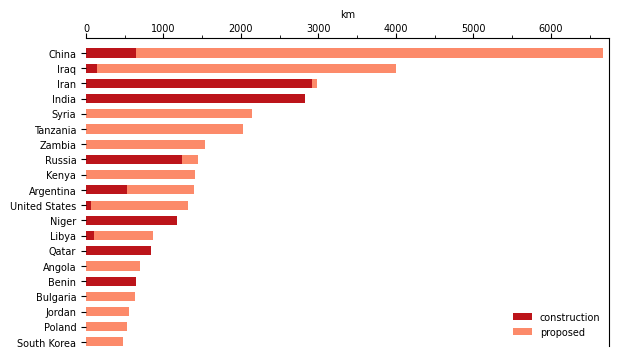

In [219]:
sel_cmap = matplotlib.cm.get_cmap('Reds')
#tracker_operating = sel_cmap(0.999)
#tracker_construction = sel_cmap(0.8)
#tracker_proposed = sel_cmap(0.6)
#tracker_shelved = sel_cmap(0.4)
#tracker_cancelled = sel_cmap(0.2)

font_size = 7
fig = mp.figure(figsize=(6.75,4))
nbars=20

country_order = km_by_country_df.index[:nbars][::-1]

ax = fig.add_subplot(111)

ax.barh(numpy.arange(nbars), 
        km_by_country_df.loc[country_order]['construction'].values, 
        facecolor=sel_cmap(0.8),
        label='construction', height=0.6)

ax.barh(numpy.arange(nbars), 
        km_by_country_df.loc[country_order]['proposed'].values, 
        left=km_by_country_df.loc[country_order]['construction'].values, 
        facecolor=sel_cmap(0.4),
        label='proposed', height=0.6)

ax.set_yticks(numpy.arange(nbars))
ax.set_yticklabels(km_by_country_df.index[:nbars][::-1])
ax.tick_params(labelsize=font_size)
ax.tick_params('x', pad=0)
ax.set_xlim(0,6750)
ax.set_ylim(-.25,20)
ax.set_xlabel('km', size=font_size)#, labelpad=10)
ax.xaxis.set_ticks_position('top')
ax.xaxis.set_label_position('top')

ax.legend(fontsize=font_size, frameon=False, loc='lower right')

#ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)

ax.xaxis.set_minor_locator(matplotlib.ticker.AutoMinorLocator(2))

mp.savefig('saved-figures/oil-pipelines_top-20-countries-no-cancelled-shelved.png',
          bbox_inches='tight', 
          transparent=True,
          dpi=600)

mp.savefig('saved-figures/oil-pipelines_top-20-countries-no-cancelled-shelved.pdf',
          bbox_inches='tight', 
          transparent=True)

In [184]:
# ratio of China to India (how many times larger is km of Chinese pipelines than India?)
km_by_country_df.loc['China']['proposed+construction']/km_by_country_df.loc['India']['proposed+construction']

/var/folders/fl/t07mc8053p33mn6mdmvp45580000gn/T/ipykernel_8458/3294416762.py:2: RuntimeWarning: divide by zero encountered in scalar divide
  km_by_country_df.loc['China']['proposed+construction']/km_by_country_df.loc['India']['proposed+construction']


inf

# parent analysis

In [81]:
owner_parent_calculations_df = pandas.DataFrame()
# needs country, km in each country columns as well

for idx,row in country_ratios_df.loc[(country_ratios_df.Fuel=='Oil')&(country_ratios_df.Status.isin(['proposed','construction']))].iterrows():
    parent_string = pipes_df_orig.loc[pipes_df_orig.ProjectID==row.ProjectID].Parent.values[0]
    #print(parent_string)
    parent_list = re.sub(' \[.*?\]', '', parent_string).split('; ') # all entries must have an "Owner [%]" syntax, so [unknown %] is included
    percent_list = [float(i.rstrip('%'))/100. for i in re.findall('\\d+(?:\\.\\d+)?%', parent_string)]
    #print(percent_list)

    if parent_list.__len__()!=percent_list.__len__():
        if percent_list==[]:
            percent_list = [1/parent_list.__len__() for i in parent_list]
        else:
            nmissing = parent_list.__len__()-percent_list.__len__()
            # distribute nans evenly
            total = numpy.nansum(percent_list)
            leftover = 1-total
            percent_list += [leftover/nmissing]*nmissing

    # for when database isn't completely filled in for owners:
    for p_idx,parent in enumerate(parent_list):
        if parent not in parents_df.index.to_list():
            parents_df.loc[parent,'ParentHQCountry']='Unknown'
        owner_parent_calculations_df = pandas.concat([owner_parent_calculations_df, 
                                                      pandas.DataFrame([{'Parent':parent, 'ProjectID':row.ProjectID, 
                                                                         'FractionOwnership':percent_list[p_idx],
                                                                         'ParentHQCountry':parents_df.loc[parents_df.index==parent]['ParentHQCountry'].values[0],
                                                                         'PipelineCountry':row.Country,
                                                                         'Status':row.Status,
                                                                         'MergedKmByCountry':row.MergedKmByCountry,
                                                                         'MergedKmByPipeline':row.MergedKmByPipeline,
                                                                         'CapacityBOEd':row.CapacityBOEd}])])

owner_parent_calculations_df['KmOwnershipByCountry'] = owner_parent_calculations_df.FractionOwnership*owner_parent_calculations_df.MergedKmByCountry

## print out leading parent companies

In [83]:
parent_country_km_df = \
owner_parent_calculations_df.loc[#(owner_parent_calculations_df.PipelineCountry.isin(region_df_touse.Country.tolist()))&
                                 (owner_parent_calculations_df.Status.isin(['proposed','construction']))]

parent_country_km_df_table = pandas.DataFrame(index=parent_country_km_df.Parent.unique().tolist(),
                                             columns=['Pipeline Country Locations','Owner Headquarters Country',
                                                      'proposed','construction','In Development (proposed + construction)','ProjectIDs'])

parent_country_km_df_table['proposed'] = parent_country_km_df.loc[parent_country_km_df.Status=='proposed'].groupby('Parent').sum('KmOwnershipByCountry')[['KmOwnershipByCountry']]
parent_country_km_df_table['construction'] = parent_country_km_df.loc[parent_country_km_df.Status=='construction'].groupby('Parent').sum('KmOwnershipByCountry')[['KmOwnershipByCountry']]

parent_country_km_df_table = parent_country_km_df_table.loc[parent_country_km_df_table.index!='']

In [84]:
pandas.options.display.max_colwidth = 500

country_agg_df = pandas.DataFrame(owner_parent_calculations_df.groupby(['Parent']).PipelineCountry.agg(lambda x: ', '.join(x.unique())))
projectid_agg_df = pandas.DataFrame(owner_parent_calculations_df.groupby(['Parent']).ProjectID.agg(lambda x: ', '.join(x.unique())))
parent_country_km_df_table['Pipeline Country Locations'] = country_agg_df.PipelineCountry
parent_country_km_df_table['Number of Projects'] = owner_parent_calculations_df.groupby(['Parent']).ProjectID.count()
parent_country_km_df_table['ProjectIDs'] = projectid_agg_df.ProjectID
parent_country_km_df_table['Owner Headquarters Country'] = parent_country_km_df.drop_duplicates('Parent').set_index('Parent').ParentHQCountry
parent_country_km_df_table['In Development (proposed + construction)'] = parent_country_km_df_table[['proposed','construction']].sum(axis=1, min_count=0)
parent_country_km_df_table.loc[~parent_country_km_df_table.index.isin(['Not in database','Unknown'])].replace(numpy.nan, '').sort_values('In Development (proposed + construction)', ascending=False)[:20]

,Pipeline Country Locations,Owner Headquarters Country,Proposed,Construction,In Development (Proposed + Construction),ProjectIDs,Number of Projects
Iran Ministry of Petroleum,Iran,Iran,57.0,"1,978.0","2,035.0","P2221, P2222, P2226, P2229, P3848, P5287, P5335, P5357, P5358, P5370, P5372, P5373",12
China National Petroleum Corporation,"Niger, Benin, Nigeria",China,,"1,950.0","1,950.0",P1328,3
Iraq Ministry of Oil,"Jordan, Iraq",Iraq,"1,558.0",195.0,"1,753.0","P0544, P3879, P5240, P5245, P5259, P5260, P5261, P5284, P5285, P5291",12
Numaligarh Refinery Limited,India,India,,"1,630.0","1,630.0",P3843,1
TotalEnergies SE,"Kenya, South Sudan, Tanzania, Uganda",France,"1,329.0",,"1,329.0","P0531, P0538, P0541",5
Indian Oil Corporation,India,India,"1,194.0",,"1,194.0",P3889,1
Rosneft,"Greece, Türkiye, Bulgaria, Russia",Russia,"1,190.0",,"1,190.0","P0667, P3675, P3676, P3677",6
Government of Zambia,"Tanzania, Zambia",Zambia,"1,140.6",,"1,140.6",P2481,2
YPF,Argentina,Argentina,894.2,150.0,"1,044.2","P2034, P5446, P5447",3
Canada Development Investment Corporation,Canada,Canada,,980.0,980.0,P0033,1


### how many of the projects for each owner do we have capacity data for? (add fraction)

## emissions estimates

In [31]:
# kuhne paper, for oil
co2_rate = 152.789 # number is 152,789 tCO2/year emissions per kilobarrel per day, divide by 1000 to get per bpd (bpd=BOEd)

### total emissions globally (known capacity is at about 67%)

### count fraction of available capacity information

count

In [32]:
pipes_df_subset = pipes_df_orig.loc[(pipes_df_orig.Status.isin(['construction','proposed']))&
                                     (pipes_df_orig.Fuel=='Oil')]
pipes_df_subset.loc[~pipes_df_subset['CapacityBcm/y'].isna()].groupby('StartRegion')['CapacityBOEd'].size()
#pipes_df_subset.groupby('StartRegion')['CapacityBcm/y'].size()

StartRegion
East Asia                          18
Eurasia                             2
Europe                              8
Latin America and the Caribbean     2
Middle East and North Africa       18
North America                      21
SE Asia                             2
South Asia                          2
Sub-Saharan Africa                  6
Name: CapacityBOEd, dtype: int64

fraction

In [33]:
pandas.options.display.float_format = '{:,.3f}'.format
pandas.DataFrame(pipes_df_subset.loc[
    ~pipes_df_subset['CapacityBcm/y'].isna()].groupby(
    'StartRegion')['CapacityBcm/y'].size()/pipes_df_subset.groupby(
    'StartRegion')['CapacityBOEd'].size()).sort_values(by=0, ascending=False)

,0
StartRegion,
SE Asia,1.000
Sub-Saharan Africa,1.000
North America,0.808
Europe,0.800
Latin America and the Caribbean,0.667
East Asia,0.643
Middle East and North Africa,0.600
South Asia,0.400
Eurasia,0.222


In [34]:
median_capacity = pipes_df_orig.loc[pipes_df_orig.Fuel=='Oil']['CapacityBcm/y'].median()

In [35]:
abs_dist_from_med_capacity = abs(pipes_df_orig.loc[pipes_df_orig.Fuel=='Oil']['CapacityBcm/y']-
                                 pipes_df_orig.loc[pipes_df_orig.Fuel=='Oil']['CapacityBcm/y'].median()).median()

In [36]:
pipes_df_orig['CapacityBcm/y'].mean()

275.13983333333334

In [37]:
pipes_df_orig['CapacityBcm/y'].std()

661.9561514922354

In [38]:
print(median_capacity)
print(abs_dist_from_med_capacity)

475.26
316.84000000000003


median capacity for a pipeline is about 4.14 bcm/y

median abs dist from the median is about 3.5.

# cost estimates (pipeline cost per km)

throwing out any estimates larger than USD 10 million per km for taking regional estimates

## pick out high and low quantiles

In [39]:
temp_df = pipes_df_orig.loc[(~pipes_df_orig.CostUSDPerKm.isnull())&
                            (pipes_df_orig.Fuel=='Oil')]
qlo_val = 0.025
qhi_val = 0.975

q_lo=temp_df['CostUSDPerKm'].quantile(qlo_val)
q_hi=temp_df['CostUSDPerKm'].quantile(qhi_val)
print(temp_df['CostUSDPerKm'].quantile(qlo_val))
print(temp_df['CostUSDPerKm'].quantile(qhi_val))

temp_df = temp_df.loc[temp_df['CostUSDPerKm'].between(q_lo, q_hi, inclusive='neither')]

67935.41416150001
16097583.484999996


In [40]:
# pull out only pipelines that have a KNOWN length AND a cost
country_ratios_with_length_and_cost_df = country_ratios_df.loc[(country_ratios_df['Fuel']=='Oil') & 
                                                               (country_ratios_df['CostUSDPerKm'].notna()) & 
                                                               (country_ratios_df['LengthKnownKmByCountry'].notna()) #&
                                                               #(country_ratios_df['LengthKnownKm']!=0) &
                                                               #(country_ratios_df['CostUSDPerKm']<10e6)
                                                              ]

country_ratios_with_length_and_cost_df = country_ratios_with_length_and_cost_df.loc[
    country_ratios_with_length_and_cost_df['CostUSDPerKm'].between(q_lo, q_hi, inclusive='neither')]
#country_ratios_with_length_and_cost_df = country_ratios_with_length_and_cost_df[~country_ratios_with_length_and_cost_df.ProjectID.isin(outliers_projectids)]

### global mean value

In [41]:
country_ratios_with_length_and_cost_df['CostUSDPerKm'].drop_duplicates().mean()

2742488.285809524

### calculate regional costs

In [42]:
pipes_oil_costs_region_df = pandas.DataFrame(0, index=region_list, columns=['CostUSDPerKm','DataPoints'])#,'NumberOfLengths'])

for region in region_list:
    print(region)
    country_ratios_region_df = country_ratios_with_length_and_cost_df.loc[country_ratios_with_length_and_cost_df['Region']==region,:]
    pipes_oil_costs_region_df.loc[region,'CostUSDPerKm'] = country_ratios_region_df['CostUSDPerKm'].mean()
    pipes_oil_costs_region_df.loc[region,'DataPoints'] = list(set(country_ratios_region_df['ProjectID'])).__len__()


Australia and New Zealand
East Asia
Eurasia
Europe
Latin America and the Caribbean
Middle East and North Africa
North America
SE Asia
South Asia
Sub-Saharan Africa


In [43]:
country_ratios_region_df['CostUSDPerKm'].mean()

4534482.848888889

In [44]:
pandas.options.display.float_format = '{:,.3f}'.format
temp_df = pipes_oil_costs_region_df.copy()
temp_df['CostUSDPerKm'] = temp_df['CostUSDPerKm']/1e6
temp_df.sort_values('CostUSDPerKm', ascending=False)#.loc[region]['CostUSDPerKm']

,CostUSDPerKm,DataPoints
Sub-Saharan Africa,4.534,4
East Asia,3.570,19
North America,3.204,31
Middle East and North Africa,3.098,22
South Asia,2.431,3
Europe,2.353,9
Eurasia,2.071,8
Latin America and the Caribbean,1.597,8
Australia and New Zealand,1.214,6
SE Asia,0.939,6


### calculate country-level costs

# tables etc.

## table for regional totals

In [45]:
if 'Total' in km_by_region_df.index:
    km_by_region_df.drop(index='Total', inplace=True)   
    total = km_by_region_df.sum(axis=0)
    total.name='Total'
    km_by_region_df = km_by_region_df.append(total)

else:
    total = km_by_region_df.sum(axis=0)
    total.name='Total'
    km_by_region_df = km_by_region_df.append(total)

km_by_region_df

/var/folders/fl/t07mc8053p33mn6mdmvp45580000gn/T/ipykernel_76998/997741405.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  km_by_region_df = km_by_region_df.append(total)


,Proposed,Construction,Proposed+Construction,Shelved,Cancelled,Operating,Idle,Mothballed,Retired
Sub-Saharan Africa,"6,288.750","1,950.000","8,238.750",986.170,"2,100.000","8,932.050",0.000,0.000,0.000
Middle East and North Africa,"4,523.740","2,493.000","7,016.740","1,544.660","6,082.170","33,979.620",0.000,"3,208.330","1,785.540"
North America,"2,705.360","1,258.700","3,964.060","8,264.230","31,342.880","113,461.790",0.000,0.000,"6,453.810"
South Asia,"1,206.470","2,070.000","3,276.470",0.000,"1,691.000","10,186.960",0.000,0.000,0.000
Europe,"2,719.040",207.000,"2,926.040",0.000,"7,042.340","30,364.100","1,474.690",815.700,0.000
East Asia,"1,538.700",440.000,"1,978.700",0.000,"8,480.640","28,661.020",46.350,0.000,"7,365.150"
Eurasia,"1,494.200",220.180,"1,714.380",95.000,"2,692.120","56,159.080",837.000,"1,625.490","1,401.900"
Latin America and the Caribbean,"1,225.000",150.000,"1,375.000",55.000,"3,937.830","20,460.130",0.000,425.000,0.000
SE Asia,228.020,342.000,570.020,0.000,306.000,"2,526.270",0.000,0.000,0.000
Australia and New Zealand,0.000,0.000,0.000,0.000,0.000,"1,848.870",0.000,0.000,187.000


## table for km by country

In [46]:
# saves all countries to an Excel file for reference

km_by_country_df.sort_values('proposed+construction', ascending=False)

if 'Total' in km_by_country_df.index:
    km_by_country_df.drop(index='Total', inplace=True)   
    total = km_by_country_df.sum(axis=0)
    total.name='Total'
    km_by_country_df = km_by_country_df.append(total)

else:
    total = km_by_country_df.sum(axis=0)
    total.name='Total'
    km_by_country_df = km_by_country_df.append(total)

km_by_country_df.to_excel('saved-tables/oil-pipelines-km-by-country.xlsx')

/var/folders/fl/t07mc8053p33mn6mdmvp45580000gn/T/ipykernel_76998/1092591467.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  km_by_country_df = km_by_country_df.append(total)


# table for stranded asset calculations

## country-level capex estimates

In [47]:
pipes_oil_costs_region_df.sort_values('CostUSDPerKm', ascending=False)

,CostUSDPerKm,DataPoints
Sub-Saharan Africa,"4,534,482.849",4
East Asia,"3,570,410.214",19
North America,"3,204,357.122",31
Middle East and North Africa,"3,097,873.705",22
South Asia,"2,430,679.657",3
Europe,"2,352,507.729",9
Eurasia,"2,070,740.973",8
Latin America and the Caribbean,"1,596,749.204",8
Australia and New Zealand,"1,213,941.655",6
SE Asia,"938,922.139",6


In [48]:
country_ratios_oil_df.reset_index(drop=True, inplace=True)
country_ratios_oil_df.loc[:,'CostUSDEstimate'] = numpy.nan

for idx,row in country_ratios_oil_df.iterrows():
    # calculate cost
    cntry = row.Country
    region = row.Region
    km_by_cntry = row.LengthKnownKmByCountry
    #print(row.PipelineName)
    country_ratios_oil_df.loc[idx,'CostUSDEstimate'] = pipes_oil_costs_region_df.loc[region, 'CostUSDPerKm'] * km_by_cntry

# replace any known costs now
country_ratios_oil_df.loc[(~country_ratios_oil_df.LengthKnownKmByCountry.isna())&
                      (~country_ratios_oil_df.CostUSDPerKm.isna()),'CostUSDEstimate'] = \
country_ratios_oil_df.loc[(~country_ratios_oil_df.LengthKnownKmByCountry.isna())&
                      (~country_ratios_oil_df.CostUSDPerKm.isna()), 'LengthKnownKmByCountry'] * \
country_ratios_oil_df.loc[(~country_ratios_oil_df.LengthKnownKmByCountry.isna())&
                      (~country_ratios_oil_df.CostUSDPerKm.isna()), 'CostUSDPerKm']

country_sums_USDBillion_df = pandas.DataFrame(country_ratios_oil_df.loc[(country_ratios_oil_df.Status.isin(['construction','proposed']))].groupby('Country')['CostUSDEstimate'].sum(min_count=1)/1e9)

/var/folders/fl/t07mc8053p33mn6mdmvp45580000gn/T/ipykernel_76998/1135204043.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  country_ratios_oil_df.loc[:,'CostUSDEstimate'] = numpy.nan


In [49]:
capex_by_country_df = pandas.DataFrame(columns=status_list, index=country_list)
capex_by_region_df = pandas.DataFrame(columns=status_list, index=region_list)

print('===country-level calculations===')
for status in status_list:
    print(status)
    country_ratios_oil_df_status = country_ratios_oil_df[country_ratios_oil_df.Status==status]
    capex_by_country_df[status] = country_ratios_oil_df_status.groupby('Country')['CostUSDEstimate'].sum()/1e9

print('===regional calculations===')
for status in status_list:
    print(status)
    country_ratios_oil_df_status = country_ratios_oil_df[country_ratios_oil_df.Status==status]
    capex_by_region_df[status] = country_ratios_oil_df_status.groupby('Region')['CostUSDEstimate'].sum()/1e9

# # fill NaN with 0.0
capex_by_region_df = capex_by_region_df.fillna(0)
capex_by_country_df = capex_by_country_df.fillna(0)

===country-level calculations===
Proposed
Construction
Shelved
Cancelled
Operating
Idle
Mothballed
Retired
===regional calculations===
Proposed
Construction
Shelved
Cancelled
Operating
Idle
Mothballed
Retired


In [50]:
capex_by_region_df['proposed+construction'] = capex_by_region_df[['proposed','construction']].sum(axis=1)
#capex_by_region_df.sort_values(by='proposed+construction', inplace=True)
capex_by_region_df = capex_by_region_df[['proposed', 'construction', 'proposed+construction', 'shelved', 'cancelled', 'Operating', 'Idle', 'Mothballed', 'Retired']]
capex_by_region_df.sort_values('proposed+construction', ascending=False, inplace=True)

In [51]:
capex_by_country_df['proposed+construction'] = capex_by_country_df[['proposed','construction']].sum(axis=1)
#capex_by_country_df.sort_values(by='proposed+construction', inplace=True)
capex_by_country_df = capex_by_country_df[['proposed', 'construction', 'proposed+construction', 'shelved', 'cancelled', 'Operating', 'Idle', 'Mothballed', 'Retired']]
capex_by_country_df.sort_values('proposed+construction', ascending=False, inplace=True)

In [52]:
if 'Total' in capex_by_region_df.index:
    capex_by_region_df.drop(index='Total', inplace=True)   
    total = capex_by_region_df.sum(axis=0)
    total.name='Total'
    capex_by_region_df = capex_by_region_df.append(total)

else:
    total = capex_by_region_df.sum(axis=0)
    total.name='Total'
    capex_by_region_df = capex_by_region_df.append(total)

/var/folders/fl/t07mc8053p33mn6mdmvp45580000gn/T/ipykernel_76998/2444263024.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  capex_by_region_df = capex_by_region_df.append(total)


In [53]:
if 'Total' in capex_by_country_df.index:
    capex_by_country_df.drop(index='Total', inplace=True)   
    total = capex_by_country_df.sum(axis=0)
    total.name='Total'
    capex_by_country_df = capex_by_country_df.append(total)

else:
    total = capex_by_country_df.sum(axis=0)
    total.name='Total'
    capex_by_country_df = capex_by_country_df.append(total)

/var/folders/fl/t07mc8053p33mn6mdmvp45580000gn/T/ipykernel_76998/3950818690.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  capex_by_country_df = capex_by_country_df.append(total)


In [54]:
pandas.options.display.float_format = '{:,.1f}'.format
capex_by_region_df

,Proposed,Construction,Proposed+Construction,Shelved,Cancelled,Operating,Idle,Mothballed,Retired
Middle East and North Africa,40.7,7.4,48.1,1.7,6.0,94.2,0.0,4.9,5.5
North America,8.9,17.9,26.8,34.3,87.2,352.2,0.0,0.0,20.7
Sub-Saharan Africa,19.1,7.0,26.1,0.0,9.5,31.3,0.0,0.0,0.0
Europe,11.6,0.1,11.8,0.0,9.4,70.5,2.8,1.9,0.0
South Asia,1.2,5.4,6.5,0.0,4.1,21.9,0.0,0.0,0.0
East Asia,4.8,1.2,6.0,0.0,23.0,91.7,0.2,0.0,19.8
Eurasia,3.1,0.3,3.4,0.2,5.4,112.7,1.7,3.4,2.9
Latin America and the Caribbean,2.6,0.3,2.8,0.1,8.2,32.4,0.0,0.2,0.0
SE Asia,0.0,0.3,0.3,0.0,0.4,2.4,0.0,0.0,0.0
Australia and New Zealand,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.2


## print out country-level stranded assets for report discussion

## in-dev for each country in list

In [55]:
country_sums_USDBillion_df.replace(numpy.nan, 0).sort_values('CostUSDEstimate', ascending=False)

,CostUSDEstimate
Country,
Iraq,23.6
Canada,17.5
Jordan,9.6
United States,9.3
Tanzania,8.0
Zambia,7.0
Syria,6.8
China,6.0
Iran,6.0


In [56]:
#pandas.options.display.float_format = '{:,.1f}'.format
these_countries = ['Canada','United States','Tanzania','Poland','India']

for cntry in these_countries:
    print(cntry)
    cntry_region = country_ratios_df.loc[country_ratios_df.Country==cntry]['Region'].to_list()[0]
    print(km_by_country_df.loc[cntry]['proposed'], ' km proposed')
    print(km_by_country_df.loc[cntry]['construction'], ' km in construction')
    print(km_by_country_df.loc[cntry]['proposed+construction'], ' total km in development')
    print(country_sums_USDBillion_df.loc[cntry], 'USD')
    print(country_ratios_oil_df.loc[(country_ratios_oil_df.Country==cntry)&
                          (country_ratios_oil_df.Status=='construction')]['CostUSDEstimate'].sum()/1e9, 'construction capex')
    print(country_ratios_oil_df.loc[(country_ratios_oil_df.Country==cntry)&
                          (country_ratios_oil_df.Status=='proposed')]['CostUSDEstimate'].sum()/1e9, 'proposed capex')
    print()

Canada
0.0  km proposed
1130.0  km in construction
1130.0  total km in development
CostUSDEstimate   17.5
Name: Canada, dtype: float64 USD
17.520000005300002 construction capex
0.0 proposed capex

United States
2705.36  km proposed
128.7  km in construction
2834.06  total km in development
CostUSDEstimate   9.3
Name: United States, dtype: float64 USD
0.4124007615389999 construction capex
8.906975927556017 proposed capex

Tanzania
2025.37  km proposed
0.0  km in construction
2025.37  total km in development
CostUSDEstimate   8.0
Name: Tanzania, dtype: float64 USD
0.0 construction capex
7.9501763653557775 proposed capex

Poland
529.53  km proposed
0.0  km in construction
529.53  total km in development
CostUSDEstimate   5.2
Name: Poland, dtype: float64 USD
0.0 construction capex
5.1770853191878 proposed capex

India
1194.0  km proposed
1630.0  km in construction
2824.0  total km in development
CostUSDEstimate   5.1
Name: India, dtype: float64 USD
3.9620078403666668 construction capex
1.1

# numbers for report

## amount already being constructed

In [57]:
# fraction of pipelines under construction compared to all in development
# this number is different from below because it's skipping some pipelines
km_by_country_total = km_by_country_df.sum(axis=0)
km_by_country_total['construction']/km_by_country_total['proposed+construction']

0.2939740168756375

In [58]:
# this fraction is on the full database, rather than only the pipelines that we estimate length for
total['construction']/total['proposed+construction']

0.3021316807645021

## capacity/potential emissions in development globally

In [59]:
pipes_df_subset.CapacityBOEd

3285   290,000.0
3398   800,000.0
3418    65,000.0
3422   160,000.0
3425   246,000.0
          ...   
4446   286,000.0
4447         NaN
4469    95,000.0
4500   160,000.0
4501         NaN
Name: CapacityBOEd, Length: 120, dtype: object

In [60]:
pipes_df_subset = pipes_df_orig.loc[(pipes_df_orig.Status.isin(['construction']))&
                                     (pipes_df_orig.Fuel=='Oil')]
cap_sum = pipes_df_subset['CapacityBOEd'].sum()
print(cap_sum / 1e6, 'million bpd')
print(cap_sum * co2_rate / 1e9, 'billion tonnes CO2')

9.66068329 million bpd
1.4760461391958097 billion tonnes CO2


In [61]:
pipes_df_subset = pipes_df_orig.loc[(pipes_df_orig.Status.isin(['proposed']))&
                                     (pipes_df_orig.Fuel=='Oil')]
cap_sum = pipes_df_subset['CapacityBOEd'].sum()
print(cap_sum / 1e6, 'million bpd')
print(cap_sum * co2_rate / 1e9, 'billion tonnes CO2')

36.886836450000004 million bpd
5.63590285435905 billion tonnes CO2


In [62]:
pipes_df_subset = pipes_df_orig.loc[(pipes_df_orig.Status.isin(['construction','proposed']))&
                                     (pipes_df_orig.Fuel=='Oil')]
cap_sum = pipes_df_subset['CapacityBOEd'].sum()
print(cap_sum / 1e6, 'million bpd')
print(cap_sum * co2_rate / 1e9, 'billion tonnes CO2')

46.54751974000001 million bpd
7.111948993554861 billion tonnes CO2


## total number of pipelines in dev

In [63]:
pipes_df_orig.loc[(pipes_df_orig.Fuel=='Oil')&
                  (pipes_df_orig.Status.isin(['proposed','construction']))]['LengthMergedKm'].sum()

31059.8

## top 10 pipelines

In [64]:
country_ratios_oil_df.loc[country_ratios_oil_df.Status.isin(['proposed','construction'])].groupby(
    'ProjectID')['CostUSDEstimate'].sum(min_count=0).sum()/1e9

131.8974248083588

In [65]:
costs_temp_df = country_ratios_oil_df.loc[country_ratios_oil_df.Status.isin(['proposed','construction'])].groupby('ProjectID')[['CostUSDEstimate']].sum(min_count=0)
#country_ratios_oil_df.loc[country_ratios_oil_df.ProjectID.isin(table_for_top10['ProjectID'].values)]['CostUSDEstimate']

In [66]:
table_for_top10 = pipes_df_orig.loc[(pipes_df_orig.Fuel=='Oil')&
                  (pipes_df_orig.Status.isin(['proposed','construction']))].sort_values(
    'LengthKnownKm', ascending=False)[['PipelineName','LengthKnownKm','CapacityBOEd','Countries','Status','StartYearEarliest','Wiki','ProjectID']].set_index('PipelineName')[:15]

table_for_top10 = table_for_top10.reset_index()
table_for_top10.set_index('ProjectID', inplace=True)
table_for_top10['CostUSDTotalEstimate'] = costs_temp_df[:]/1e9
table_for_top10 = table_for_top10.reset_index()
table_for_top10.set_index('PipelineName', inplace=True)
table_for_top10.replace(numpy.nan,'')[['LengthKnownKm','CapacityBOEd','Countries','Status','StartYearEarliest','Wiki','CostUSDTotalEstimate']]

,LengthKnownKm,CapacityBOEd,Countries,Status,StartYearEarliest,Wiki,CostUSDTotalEstimate
PipelineName,,,,,,,
Niger–Benin Oil Pipeline,"1,950.0","90,000.0","Niger, Benin",Construction,"2,024.0",https://www.gem.wiki/Niger%E2%80%93Benin_Oil_P...,7.0
Tazama Oil Pipeline,"1,710.0","22,000.0","Tanzania, Zambia",Proposed,,https://www.gem.wiki/Tazama_Oil_Pipeline,7.8
Paradip Numaligarh Crude Pipeline (PNCPL),"1,630.0",,India,Construction,"2,024.0",https://www.gem.wiki/Paradip_Numaligarh_Crude_...,4.0
East African Crude Oil Pipeline (EACOP),"1,444.0","246,000.0","Uganda, Tanzania",Proposed,"2,025.0",https://www.gem.wiki/East_African_Crude_Oil_Pi...,5.0
Angola-Zambia Oil Pipeline,"1,400.0","1,000,000.0","Angola, Zambia",Proposed,"2,026.0",https://www.gem.wiki/Angola-Zambia_Oil_Pipeline,6.3
New Mundra–Panipat Oil Pipeline,"1,194.0","430,067.8",India,Proposed,"2,024.0",https://www.gem.wiki/New_Mundra%E2%80%93Panipa...,1.2
Basra-Aqaba Oil Pipeline,"1,154.0","1,000,000.0","Iraq, Jordan",Proposed,,https://www.gem.wiki/Basra-Aqaba_Oil_Pipeline,22.0
Seahorse Pipeline,"1,126.5","800,000.0",United States,Proposed,"2,022.0",https://www.gem.wiki/Seahorse_Pipeline,3.6
Trans Mountain Oil Pipeline,980.0,"290,000.0",Canada,Construction,"2,023.0",https://www.gem.wiki/Trans_Mountain_Oil_Pipeline,17.1


## biggest pipeline projects by name in China, rather than individual ProjectID

In [67]:
biggest_pipeline_names_table = pandas.DataFrame(pipes_df_orig.loc[(pipes_df_orig.Fuel=='Oil')&
                                                                  (pipes_df_orig.Status.isin(['proposed','construction']))&
                                                                  (pipes_df_orig.Countries.str.contains('China'))].groupby(['PipelineName','Status','Wiki'])['LengthMergedKm'].sum(min_count=1).sort_values(ascending=False)[:19])

biggest_pipeline_names_table

,,,LengthMergedKm
PipelineName,Status,Wiki,
Rizhao–Yizheng Parallel Oil Pipeline,Proposed,https://www.gem.wiki/Rizhao%E2%80%93Yizheng_Parallel_Oil_Pipeline,400.0
Dongjiakou–Yishui–Zibo Oil Pipeline,Proposed,https://www.gem.wiki/Dongjiakou%E2%80%93Yishui%E2%80%93Zibo_Oil_Pipeline,217.0
Rizhao–Zhanhua Oil Pipeline,Proposed,https://www.gem.wiki/Rizhao%E2%80%93Zhanhua_Oil_Pipeline,180.0
Huangdao-Lanshan Oil Pipeline,Proposed,https://www.gem.wiki/Huangdao-Lanshan_Oil_Pipeline,154.0
Dongying–Guangrao Oil Pipeline,Construction,https://www.gem.wiki/Dongying%E2%80%93Guangrao_Oil_Pipeline,150.0
Panjin–Jinzhou Oil Pipeline,Construction,https://www.gem.wiki/Panjin%E2%80%93Jinzhou_Oil_Pipeline,140.0
Jianli–Qianjiang Oil Pipeline,Construction,https://www.gem.wiki/Jianli%E2%80%93Qianjiang_Oil_Pipeline,128.0
Yantai Port Xigang District–Longkou Yulong Island Oil Pipeline,Proposed,https://www.gem.wiki/Yantai_Port_Xigang_District%E2%80%93Longkou_Yulong_Island_Oil_Pipeline,101.0
Huangze Operation Area-Caojing Crude Oil Submarine Pipeline,Proposed,https://www.gem.wiki/Huangze_Operation_Area-Caojing_Crude_Oil_Submarine_Pipeline,90.0


## km of pipeline with 2023, 2024 start years

In [68]:
# for the key points
print(pipes_indev_startyear.loc['construction',2023],
      pipes_indev_startyear.loc['construction',2024])

print(pipes_indev_startyear.loc['proposed',2023],
      pipes_indev_startyear.loc['proposed',2024])

2601.1 3730.0
1235.56 2403.5


## km of oil pipelines globally in development

note this doesn't match up exactly with regional length calculations

In [69]:
pipes_df_calc = pipes_df_orig.copy()
pipes_df_calc.replace('--',numpy.nan,inplace=True)
pipes_df_calc[(pipes_df_calc['Status'].isin(['proposed','construction'])) &
        (pipes_df_calc['Fuel']=='Oil')]['LengthMergedKm'].sum()

31059.8

In [70]:
regional_km_sums_df = pandas.DataFrame(index=region_list, columns=status_list)

for status in status_list:
    regional_km_sums_df[status] = pipes_df_calc[(pipes_df_calc['Fuel']=='Oil') &
                                                (pipes_df_calc['Status']==status)].groupby('StartRegion')['LengthMergedKm'].sum()

regional_km_sums_df['P+C'] = regional_km_sums_df[['proposed','construction']].sum(axis=1)
total_row = regional_km_sums_df.sum(axis=0)
total_row.name = 'Total'
#regional_km_sums_df.append(total_row)

## country shares analysis

In [71]:
country_ratios_df[(country_ratios_df['Status'].isin(['proposed','construction'])) &
               (country_ratios_df['Fuel']=='Oil')]['MergedKmByCountry'].sum()

31060.159999999996

## num in dev globally, whether capacity expansions or not

In [72]:
print("capacity expansion projects:",
    pipes_df_orig.loc[(pipes_df_orig.Fuel=='Oil')&
                  (pipes_df_orig.Status.isin(['proposed','construction']))&
                  (pipes_df_orig.Route.isin(['Capacity expansion only','Bidirectionality upgrade only']))].shape)

print("non-zero length projects:",
      pipes_df_orig.loc[(pipes_df_orig.Fuel=='Oil')&
                  (pipes_df_orig.Status.isin(['proposed','construction']))&
                  (~pipes_df_orig.Route.isin(['Capacity expansion only','Bidirectionality upgrade only']))].shape)

capacity expansion projects: (6, 93)
non-zero length projects: (114, 93)


In [73]:
print(pipes_df_orig.loc[(pipes_df_orig.Fuel=='Oil')&
                  (pipes_df_orig.Status.isin(['proposed','construction']))&
                  (pipes_df_orig.Route.isin(['Capacity expansion only','Bidirectionality upgrade only']))]['CapacityBOEd'])

print(pipes_df_orig.loc[(pipes_df_orig.Fuel=='Oil')&
                  (pipes_df_orig.Status.isin(['proposed','construction']))&
                  (pipes_df_orig.Route.isin(['Capacity expansion only','Bidirectionality upgrade only']))][['Countries','CapacityBOEd']])

3878   220,000.0
3938    70,000.0
4004   250,000.0
4129         NaN
4265    98,301.2
4310   294,903.6
Name: CapacityBOEd, dtype: object
                    Countries CapacityBOEd
3878            United States    220,000.0
3938            United States     70,000.0
4004            United States    250,000.0
4129                    China          NaN
4265  Austria, Germany, Italy     98,301.2
4310                   Russia    294,903.6
